# Performing Classification analysis on SECOM Dataset to detect fault in the yeild. 

In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Train Data

In [12]:
class load():
    def data(file_path):
        import numpy as np 
        import pandas as pd
        data = pd.DataFrame(np.loadtxt(file_path))
        data.columns = ["X" + str(i) for i in range(590)]
        return data

    def label(file_path):
        import numpy as np 
        import pandas as pd
        label = pd.read_csv(file_path,sep= ' ', header=None)
        col = label.columns.values
        label = label.drop(col[1], axis=1)
        return label

## Data Preprocessing 

In [13]:
class preprocessing():
    
    ## Function is to check how many zeros and NaN values are there in each attribute/ Columns.
    def zero(data):
        import pandas as pd
        import numpy as np 
        data_old = np.array(data)
        data = data_old.T

        nan = []
        for i in range(len(data)):
            l = np.count_nonzero(np.nan_to_num(data[i]))
            count = len(data[i]) - l
            nan.append(count)  
        return nan 
    
    ### This function drop the columns having same constant value. 
    def drop(df):
        data = df.replace(np.nan, 0)
        shape = data.shape
        col = data.columns.values
        for i in range(len(col)):
            l = data[col[i]]
            mean = np.mean(l)
            count = 0
            for n in range(len(l)):
                if l[n] == mean:
                    count = count+1
            if count == len(l):
                data = data.drop(col[i], axis = 1)

        return data
    
    
    # This function first drop all the columns having missing values more than the desired threshold.
    #Once the columns are droped, the missing values are imputed by taking the mean of the values available
    #in the column.The output of the function is the pandas DataFrame with the imputed values and dropped columns. 
    # Following inputs are required for the function. 
    
    def impute(data, missing_percentage=0.5, strategy = 'mean'):
        import numpy as np
        import pandas as pd

        df = data
        s = df.shape
        col = df.columns.values
        threshold = (missing_percentage)
        for x in range(len(col)):
            l = df[col[x]]
            count = np.count_nonzero(l)
            if count <= (s[0]*(1- threshold)):
                df = df.drop([col[x]], axis = 1)

        data =  {}   
        shape = df.shape
        col1 = df.columns.values
        for i in range(shape[1]):
            l = np.nan_to_num(df[col1[i]])
            p = np.array(np.nonzero(l))[0]
            t =[]
            for n in range(len(p)):
                t.append(df[col1[i]][p[n]])
            mean = np.mean(t)
            median = np.median(t)
            for x in range(len(l)):
                if l[x] == 0:
                    if strategy == "mean":
                        l[x] = mean  
                    elif strategy == "median": 
                        l[x] = median
            d = {col1[i]: l}
            data.update(d)
        imputed_data = pd.DataFrame(data)
        data = preprocessing.drop(imputed_data)
        return data

## Feature Selection 

In [59]:
class feature_selection():
    
    ## Feature selection method using VarianceThreshold method, which eliminates the features with low variance. 
    def varianceThreshold(X,threshold=0):
        p = threshold
        col = X.columns.values
        from sklearn.feature_selection import VarianceThreshold
        sel = VarianceThreshold(threshold=(p * (1 - p)))
        sel.fit_transform(X)
        features = col[(sel.get_support(indices=True))]
        X_df = X.filter(features)
        return X_df
    
    ## Feature selection by three different models, 
    ## 1) Support Vector Classifier
    ## 2) Logistic Classifier
    ## 3) Descision Tree Classifier
    
    def model_selection(data, label, Model= "SVC"):
        from sklearn.svm import LinearSVC
        from sklearn.linear_model import LogisticRegression
        from sklearn.feature_selection import SelectFromModel
        from sklearn.ensemble import ExtraTreesClassifier
        import pandas as pd
        
        model = Model
    
        X, y = data, label
        col = X.columns.values

        lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
        Logistic_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, y)
        tree = ExtraTreesClassifier(n_estimators=100).fit(X,y)
        
        if model == "SVC":
            model = SelectFromModel(lsvc, prefit=True)
        elif model == "Logistic":
            model = SelectFromModel(Logistic_clf, prefit=True)
        elif model == "tree":
            model = SelectFromModel(tree, prefit=True)
            
        X_new = model.transform(X)
        X_new_transpose = X_new.T

        features = []
        for i in range(len(X_new_transpose)):
            for n in range(len(col)):
                if list(X_new_transpose[i]) == list(X[col[n]]):
                    features.append(col[n])
        df_selected = pd.DataFrame(X_new, columns=features)
        
        return df_selected
        
    def PCA(X):
        shape = X.shape
        com = shape[1]
        import numpy as np
        from sklearn.decomposition import PCA
        pca = PCA(n_components=com)
        pca.fit(X)
        var_explained = (pca.explained_variance_ratio_)  
        X_new = pca.fit_transform(X)
        return (X_new)
        

## Oversampling Methods 

In [15]:
def oversampling(data,label):
    from collections import Counter
    from sklearn.datasets import make_classification
    from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
    X, y = make_classification(n_classes=2, class_sep=2,
    weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
    print('Original dataset shape %s' % Counter(y))
    
    col = data.columns.values

    sm = SMOTE(random_state=42)
    X_df, y_df = sm.fit_resample(data, label)
    print('Resampled dataset shape %s' % Counter(y_df))
    
    X_df = pd.DataFrame(X_df , columns=col)
    y_df = pd.DataFrame(y_df)
    
    return X_df, y_df

## Classifier 

In [61]:
def classifier(X,Y, test_size, random_state = 2, n_estimators= 100 ):
    
    size = test_size 
    seed = random_state
    estimators = n_estimators
    
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size, random_state = seed)

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics

    clf = RandomForestClassifier(n_estimators=estimators, max_depth=None, random_state=seed, bootstrap=True)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, Y_test)
    true_data = Y_test
    pred_data = pred
    
    return clf , pred, true_data, score


def confusion_matrix(true_data, pred_data):
    
    true_data = np.array(true_data)
    pred_data = np.array(pred_data)
    true_pos = 0
    true_neg = 0
    count_neg = 0
    count_pos = 0
    for i in range(len(true_data)):
        if true_data[i] == -1 and  pred_data[i] == -1: 
            count_neg += 1
        elif true_data[i] == 1 and  pred_data[i] == 1:
            count_pos += 1
    for i in range(len(true_data)):
        if true_data[i] == 1:
            true_pos +=1
    true_neg = len(true_data) - true_pos 
    cnf = np.array([[count_neg, (true_neg-count_neg)],[(true_pos-count_pos), count_pos]])
    
    return cnf

def plot_confusion_matrix(cm,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    import itertools
#     from sklearn.model_selection import train_test_split
#     from sklearn.metrics import confusion_matrix
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    """
    
    class_names = ["Pass", "Fail"]
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Classification performance and accuracy 

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({-1: 1463, 1: 1463})
0.979296066252588
Normalized confusion matrix
[[0.97 0.03]
 [0.01 0.99]]


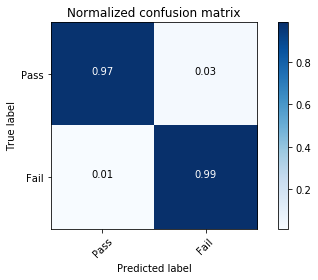

In [62]:
### Feature selection by SVC and classified using Random Forest 


file_path =  "secom.data.txt"
df = load.data(file_path)
df = preprocessing.drop(df)
df = preprocessing.impute(df, 0.5, "mean")
label_path = 'secom_labels.data.txt'
label = load.label(label_path)
featured_data = feature_selection.model_selection(df, label=label, Model="SVC")
X_over, Y_over  = oversampling(featured_data, label=label)
clf, pred, true_data, score = classifier(X_over, Y_over, 0.33)
print(score)
cnf = confusion_matrix(true_data, pred)
plt.figure()
plot_confusion_matrix(cnf, normalize=True,title='Normalized confusion matrix')

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({-1: 1463, 1: 1463})
0.984472049689441
Normalized confusion matrix
[[0.98 0.02]
 [0.01 0.99]]


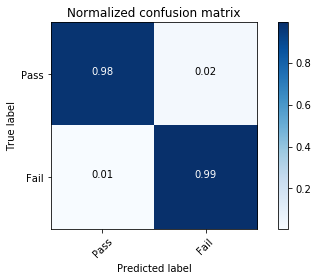

In [63]:
### Feature selection by Logistic Classifier and classified using Random Forest 

file_path =  "secom.data.txt"
df = load.data(file_path)
df = preprocessing.drop(df)
df = preprocessing.impute(df, 0.5, "mean")
label_path = 'secom_labels.data.txt'
label = load.label(label_path)
featured_data = feature_selection.model_selection(df, label=label, Model="Logistic")
X_over, Y_over  = oversampling(featured_data, label=label)
clf, pred, true_data, score = classifier(X_over, Y_over, 0.33)
print(score)
cnf = confusion_matrix(true_data, pred)
plt.figure()
plot_confusion_matrix(cnf, normalize=True,title='Normalized confusion matrix')

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({-1: 1463, 1: 1463})
0.9834368530020704
Normalized confusion matrix
[[0.98 0.02]
 [0.01 0.99]]


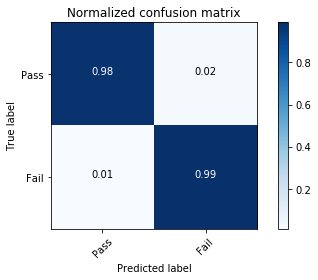

In [64]:
### Feature selection by Decision Tree and classified using Random Forest 

file_path =  "secom.data.txt"
df = load.data(file_path)
df = preprocessing.drop(df)
df = preprocessing.impute(df, 0.5, "mean")
label_path = 'secom_labels.data.txt'
label = load.label(label_path)
featured_data = feature_selection.model_selection(df, label=label, Model="tree")
X_over, Y_over  = oversampling(featured_data, label=label)
clf, pred, true_data, score = classifier(X_over, Y_over, 0.33)
print(score)
cnf = confusion_matrix(true_data, pred)
plt.figure()
plot_confusion_matrix(cnf, normalize=True,title='Normalized confusion matrix')